In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from spike_statistics.core import permutation_resampling_test, block_bootstrap

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

09:30:31 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("data_frame")
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [7]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [10]:
data = data.merge(stim_results, how='left')

In [11]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [12]:
data = data.merge(waveform_results, how='left')

In [14]:
data.bs = data.bs.astype(bool)

In [15]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [16]:
# make sure onece a cell type stays that celltype
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [17]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [18]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [19]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [21]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [25]:
for color, query, label in zip(colors, queries, labels):
    data.loc[data.eval(query), 'paradigm'] = label
    data.loc[data.eval(query), 'color'] = color    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c680d00b8>]],
      dtype=object)

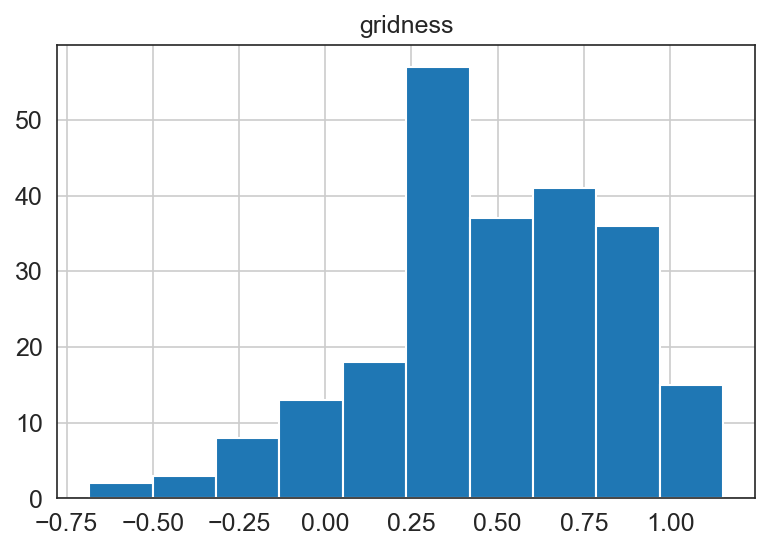

# save to expipe

In [48]:
action = project.require_action("data_frame")

In [49]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_gridcell.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_gridcell.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_not_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_inhibited.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_not_inhibited.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/data/theta_kde.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/data/stim_kde.feather',
 

In [50]:
septum_mec.analysis.registration.store_notebook(action, "15_assemble_data_frame.ipynb")